In [ ]:
!fusermount -u drive

## 드라이브 마운팅 & 워킹 디렉토리 변경

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive')

Mounted at /content/drive/MyDrive


In [ ]:
import os

path = '/content/drive/MyDrive/MyDrive/NLP-StockMarket'
os.chdir(path)

## 필요 모듈 import

In [ ]:
!pip install konlpy   # 코랩에서만 실행

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.4 MB/s 
     |████████████████████████████████| 453 kB 54.4 MB/s 


In [1]:
import pandas as pd
from tqdm import tqdm
from konlpy.tag import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import re
from datetime import datetime, timedelta
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 한글 깨짐 방지
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

# - 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
okt = Okt()

## 종목 선택, 뉴스 & 토론방 & 유튜브 데이터 통합

In [3]:
# LG화학, 삼성SDI, SK이노베이션, 고려아연, 포스코케미칼
stock_name = '삼성SDI'

In [4]:
naver_news = pd.read_csv('./data/refined_naver_news.csv', index_col=0)
daum_news = pd.read_csv('./data/refined_daum_news.csv', index_col=0)
naver_talks = pd.read_csv(f'./data/refined_naver_talks_{stock_name}.csv', index_col=0)
daum_talks = pd.read_csv(f'./data/refined_daum_talks_{stock_name}.csv', index_col=0)
youtube = pd.read_csv(f'./data/refined_youtube_{stock_name}.csv', index_col=0)

In [5]:
naver_talks['Date'] = pd.to_datetime(naver_talks['Date'])
daum_talks['Date'] = pd.to_datetime(daum_talks['Date'])

In [6]:
# 데이터 통합
news_df = pd.concat([naver_news, daum_news, naver_talks, daum_talks, youtube])

# 'Date'열의 데이터 타입이 int여서 datetime으로 변환
news_df['Date'] = pd.to_datetime(news_df['Date'].astype(str))     # str(변수) 는 자체 내장함수, 변수 하나씩밖에 적용 안됨.

# 합쳐진 데이터의 인덱스 재설정
news_df.sort_values('Date', ignore_index=True, inplace=True)

news_df

,Date,Title
0,1970-01-01 00:00:00.020210101,전고체 테마 불아
1,1970-01-01 00:00:00.020210101,금융 감독원 관계님
2,1970-01-01 00:00:00.020210101,새해 인사
3,1970-01-01 00:00:00.020210101,긴급 레버리지배배 고수익 재테크 실체
4,1970-01-01 00:00:00.020210101,삼성 sdi
...,...,...
667268,2022-07-05 00:00:00.000000000,고점대비 40 하락 올해 최대실적 전망 심텍 토비스 기아 레고켐바이오 ...
667269,2022-07-05 00:00:00.000000000,노터스 주가전망 노터스 주가 노터스 주식 노터스 주식전망 노터스 주가전망 노터스...
667270,2022-07-05 00:00:00.000000000,주식챔피언쇼 7월 4일 방송 감소 한일사료 한미반도체 신세계 I C
667271,2022-07-05 00:00:00.000000000,수젠텍 주가전망 수젠텍주가 수젠텍주식 수젠텍목표가 수젠텍매매전략


In [7]:
# 주가 데이터 시작이 1월 4일 부터여서 뉴스도 1월 4일 이전은 슬라이싱으로 없애기
news_df = news_df[news_df[news_df['Date'] == '2021-01-04'].index[0] : ]
news_df.head(2)

,Date,Title
25227,2021-01-04,한국단자 52주 신고가 경신 단기 중기 이평선 정배열로 상승세
25228,2021-01-04,현대오토에버 52주 신고가 경신 전일 외국인 대량 순매수


## KRX에서 받은 csv로 가져오기

In [8]:
stock_df = pd.read_csv(f'./data/{stock_name}_주가_데이터.csv', usecols = ['일자', '등락률'])
stock_df['일자'] = pd.to_datetime(stock_df['일자'])
stock_df.head(3)

,일자,등락률
0,2021-01-04,6.85
1,2021-01-05,2.24
2,2021-01-06,-0.87


## 주가 데이터

In [9]:
start = str(stock_df.iloc[0, 0])
end = str(stock_df.iloc[-1, 0])
print('start : ', start)
print('end : ', end)

start :  2021-01-04 00:00:00
end :  2022-06-30 00:00:00


In [10]:
# multi 분류
stock_df['updown'] = 0

stock_df.loc[stock_df.query('등락률 > 1').index, 'updown'] = 1
stock_df.loc[stock_df.query('등락률 < -1').index, 'updown'] = -1

stock_df['updown'].value_counts()

 0    149
 1    111
-1    109
Name: updown, dtype: int64

In [11]:
# 뉴스 일자 열 추가 : 예측대상(= 익일의 주가)의 일자와 맞추기 위함

news_df['일자'] = news_df['Date'] + timedelta(days = 1)
news_df.head(3)

,Date,Title,일자
25227,2021-01-04,한국단자 52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05
25228,2021-01-04,현대오토에버 52주 신고가 경신 전일 외국인 대량 순매수,2021-01-05
25229,2021-01-04,리서치알음 푸드나무 140만명 플랫폼증가익일배송 다이어트푸드 최대 수혜주,2021-01-05


# 뉴스 데이터 & 주가 데이터 합치기

In [12]:
df = news_df.merge(stock_df)

# df 칼럼명 : Date, Title, 주가의 날짜(구 : 일자), 등락률(y), updown
df.columns = [df.columns[0], df.columns[1], '주가의 날짜', '등락률(y)', 'updown']

# 기사 제목 중복 제거
df.drop_duplicates('Title', inplace = True, ignore_index = True)

print(len(df))
df['updown'].value_counts()

403719


 0    160123
 1    132553
-1    111043
Name: updown, dtype: int64

In [13]:
df.to_csv('./data/[Model6]merged_df.csv', encoding = 'utf-8-sig')

df = pd.read_csv('./data/[Model6]merged_df.csv', index_col = 0)
df['updown'].value_counts()

 0    160123
 1    132553
-1    111043
Name: updown, dtype: int64

# 감성사전 불러오기

In [14]:
sentiment_csv = pd.read_csv('./data/sentiment dictionary.csv', index_col = 0)
sentiment_csv.head()

,pos,mid,neg
0,방긋,아직,회의
1,상회,보통,바닥
2,신선,vs,이탈
3,신박,중립,떨어지
4,투혼,관망,안좋게


In [15]:
pos_li = sentiment_csv['pos'].dropna().values
mid_li = sentiment_csv['mid'].dropna().values
neg_li = sentiment_csv['neg'].dropna().values

print(f'pos_li : {len(pos_li)} 개')
print(f'mid_li : {len(mid_li)} 개')
print(f'neg_li : {len(neg_li)} 개')

pos_li : 328 개
mid_li : 11 개
neg_li : 295 개


# 감성지수 계산하는 함수 : sentimental_score()

In [16]:
def sentimental_score(df):
    # 입력받은 데이터프레임 복사 및 컬럼 추가
    df_result = df.copy()
    df_result['Pos'] = 0
    df_result['Neg'] = 0
    df_result['Mid'] = 0
    
    # 감성 지수는 긍정 : 1, 중립 : 0, 부정 : -1, 해당 데이터 제외 : 999
    df_result['감성지수'] = 999    
    
    # 감성 사전에 따른 텍스트 검출
    print('긍정 단어 검색중')
    for pos in tqdm(pos_li) :
        df_result.loc[df_result[df_result['Title'].str.contains(pos) == True].index, 'Pos'] = 1
    
    print('부정 단어 검색중')
    for neg in tqdm(neg_li) :
        df_result.loc[df_result[df_result['Title'].str.contains(neg) == True].index, 'Neg'] = 1
    
    print('중립 단어 검색중')
    for mid in tqdm(mid_li) :
        df_result.loc[df_result[df_result['Title'].str.contains(mid) == True].index, 'Mid'] = 1
    
    df_result.to_csv('./data/[Model6]pos_neg_mid_added_df_result.csv', encoding = 'utf-8-sig')



    # 모든 종류의 단어가 검출 되면 제외
    df_result.loc[df_result[(df_result['Pos'] == 1) & (df_result['Neg'] == 1) & (df_result['Mid'] == 1)].index, '감성지수'] = 999
    
    # 중립 단어가 검출되면 중립
    df_result.loc[df_result[(df_result['Pos'] == 1) & (df_result['Neg'] == 0) & (df_result['Mid'] == 1)].index, '감성지수'] = 0
    df_result.loc[df_result[(df_result['Pos'] == 0) & (df_result['Neg'] == 1) & (df_result['Mid'] == 1)].index, '감성지수'] = 0
    df_result.loc[df_result[(df_result['Pos'] == 0) & (df_result['Neg'] == 0) & (df_result['Mid'] == 1)].index, '감성지수'] = 0

    # 긍 부 중립 모두 검출 안될 경우는 일단 0이라고 했음
    df_result.loc[df_result[(df_result['Pos'] == 0) & (df_result['Neg'] == 0) & (df_result['Mid'] == 0)].index, '감성지수'] = 0

    # 긍정 단어만이 검출되면 긍정
    df_result.loc[df_result[(df_result['Pos'] == 1) & (df_result['Neg'] == 0) & (df_result['Mid'] == 0)].index, '감성지수'] = 1
    
    # 부정 단어만이 검출되면 부정
    df_result.loc[df_result[(df_result['Pos'] == 0) & (df_result['Neg'] == 1) & (df_result['Mid'] == 0)].index, '감성지수'] = -1
    
    # 긍정, 부정 단어가 둘 다 있으면 전 날 또는 당일 주가의 등락률을 보고 결정
    print('긍정 부정 둘 다 있는 경우 처리중')
    for i in tqdm(df_result.loc[df_result[(df_result['Pos'] == 1) & (df_result['Neg'] == 1) & (df_result['Mid'] == 0)].index].index) : 
        updown = 999 # 등락률을 뜻하는 updown
        
        # 해당 Title의 어제 주가가 있으면 선택
        # if sum((df_result.loc[i,'Date'] - timedelta(days = 1)) == stock_df['일자']) == 1 :  
        if sum(pd.to_datetime(df_result.loc[i, 'Date']) - timedelta(days = 1) == stock_df['일자']) == 1 :
            updown = stock_df[stock_df['일자'] == (pd.to_datetime(df_result.loc[i,'Date']) - timedelta(days = 1))]['등락률'].values[0]
        
        # 어제 주가는 없지만 당일이 있으면 당일을 선택
        # elif sum(df_result.loc[i,'Date'] == stock_df['일자']) == 1 : 
        elif sum(pd.to_datetime(df_result.loc[i,'Date']) == stock_df['일자']) == 1 :
            updown = stock_df[stock_df['일자'] == pd.to_datetime(df_result.loc[i,'Date'])]['등락률'].values[0]

        # 어제와 오늘의 주가도 없다면 이전의 주가를 찾아 탐색
        else :
            j = 2 
            while True :
                # if sum((df_result.loc[i,'Date'] - timedelta(days = j)) == stock_df['일자']) == 1 :
                if sum((pd.to_datetime(df_result.loc[i, 'Date']) - timedelta(days = j)) == stock_df['일자']) == 1 :
                    updown = stock_df[stock_df['일자'] == (pd.to_datetime(df_result.loc[i,'Date']) - timedelta(days = j))]['등락률'].values[0]
                    break
                j += 1
        
        # 절댓값이 0보다 낮은 등락률은 변화가 없다고 판단
        if updown > 1 :
            # df_result['감성지수'][i] = 1
            df_result.loc[i, '감성지수'] = 1
        elif updown < 1 :
            # df_result['감성지수'][i] = -1
            df_result.loc[i, '감성지수'] = -1
        else :
            # df_result['감성지수'][i] = 0
            df_result.loc[i, '감성지수'] = 0
    print('df_result["감성지수"] : \n',  df_result['감성지수'].value_counts())

    return df_result

In [17]:
df_result = sentimental_score(df)

긍정 단어 검색중


100%|██████████| 328/328 [00:31<00:00, 10.52it/s]


부정 단어 검색중


100%|██████████| 295/295 [00:27<00:00, 10.60it/s]


중립 단어 검색중


100%|██████████| 11/11 [00:01<00:00, 10.52it/s]


긍정 부정 둘 다 있는 경우 처리중


100%|██████████| 71853/71853 [00:39<00:00, 1820.42it/s]

df_result["감성지수"] : 
  1      203878
-1      117330
 0       81398
 999      1113
Name: 감성지수, dtype: int64


In [18]:
df_result['감성지수'].value_counts()

 1      203878
-1      117330
 0       81398
 999      1113
Name: 감성지수, dtype: int64

In [19]:
df_result = pd.read_csv('./data/[Model6]감성지수_added_df_result.csv', index_col = 0)
df_result

FileNotFoundError: [Errno 2] No such file or directory: './data/[Model6]감성지수_added_df_result.csv'

In [20]:
len(df_result)

403719

In [21]:
df_result = df_result.drop(df_result[df_result['감성지수'] == 999].index)
len(df_result)

402606

In [22]:
df_result.to_csv('./data/[Model6]감성지수_added_df_result.csv', encoding = 'utf-8-sig')

# 예측 모델 적용

In [23]:
df_result['tokenized'] = 0
df_result.dropna(how='any',inplace= True)
df_result['tokenized'] = df_result['Title'].apply(okt.morphs)   # 또는 자유롭게 라이브러리 사용

In [24]:
# tokenized 열이 추가된 df_result를 csv로.
df_result.to_csv('./data/[Model6]tokenized_added_df_result.csv', encoding = 'utf-8-sig')

## 모델 테스트 용 : 여기서부터 시작~

In [2]:
df_result = pd.read_csv('./data/[Model6]tokenized_added_df_result.csv', index_col = 0)
df_result

,Date,Title,주가의 날짜,등락률(y),updown,Pos,Neg,Mid,감성지수,tokenized
0,2021-01-04,한국단자 52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1,1,0,0,1,"['한국', '단자', '52', '주', '신고', '가', '경신', '단기',..."
1,2021-01-04,현대오토에버 52주 신고가 경신 전일 외국인 대량 순매수,2021-01-05,2.24,1,1,0,0,1,"['현대', '오토', '에버', '52', '주', '신고', '가', '경신',..."
2,2021-01-04,리서치알음 푸드나무 140만명 플랫폼증가익일배송 다이어트푸드 최대 수혜주,2021-01-05,2.24,1,1,0,0,1,"['리서치', '알음', '푸드', '나무', '140만', '명', '플랫폼', ..."
3,2021-01-04,특징주 전기차 시장 확대 2차전지주 강세,2021-01-05,2.24,1,1,0,0,1,"['특징', '주', '전기차', '시장', '확대', '2', '차전지주', '강세']"
4,2021-01-04,동화기업 52주 신고가 경신 기관 4일 연속 순매수 5 1만주,2021-01-05,2.24,1,1,0,0,1,"['동화', '기업', '52', '주', '신고', '가', '경신', '기관',..."
...,...,...,...,...,...,...,...,...,...,...
403714,2022-06-29,IBK투자증권 중소기업과 손잡고 사회취약계층 지원 나서,2022-06-30,-6.67,-1,1,0,0,1,"['IBK', '투자', '증권', '중소기업', '과', '손잡고', '사회', ..."
403715,2022-06-29,유안타증권 주가연계증권 MY ELS 5000호 공모,2022-06-30,-6.67,-1,0,0,0,0,"['유안', '타', '증권', '주', '가연', '계', '증권', 'MY', ..."
403716,2022-06-29,디지털플랫폼정부위원회 출범 위세아이텍 성장 속도 빨라질 것,2022-06-30,-6.67,-1,1,0,0,1,"['디지털', '플랫폼', '정부', '위원회', '출범', '위세', '아이', ..."
403717,2022-06-29,코오롱글로벌 경북 영덕 호지마을 풍력발전단지 건설,2022-06-30,-6.67,-1,0,0,0,0,"['코오롱', '글로벌', '경북', '영덕', '호', '지', '마을', '풍력..."


In [3]:
X_train = df_result['tokenized'].values
y_train = df_result['감성지수'].values
X_train

array(["['한국', '단자', '52', '주', '신고', '가', '경신', '단기', '중기', '이평', '선', '정', '배열', '로', '상승세']",
       "['현대', '오토', '에버', '52', '주', '신고', '가', '경신', '전일', '외국인', '대량', '순', '매수']",
       "['리서치', '알음', '푸드', '나무', '140만', '명', '플랫폼', '증가', '익일', '배송', '다이어트', '푸드', '최대', '수', '혜주']",
       ...,
       "['디지털', '플랫폼', '정부', '위원회', '출범', '위세', '아이', '텍', '성장', '속도', '빨라질', '것']",
       "['코오롱', '글로벌', '경북', '영덕', '호', '지', '마을', '풍력발전', '단지', '건설']",
       "['한국', '예', '탁', '결제', '원', '2022년', '상반기', '부산', '사이버', '보안', '협의', '회', '개최']"],
      dtype=object)

In [4]:
tokenizer = Tokenizer(len(df_result['tokenized']), oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [5]:
max_len = max(len(i) for i in X_train)
print('리뷰 최대 길이 :', max_len)

리뷰 최대 길이 : 42


In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 패딩
X_train = pad_sequences(X_train, maxlen = max_len)

In [7]:
# y label shape 맞춰주기
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)

# LSTM 모델링

In [8]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
model = Sequential()
model.add(Embedding(len(X_train), 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation = 'softmax'))

# val_loss를 관찰값으로 설정, 그 값이 감소하는 걸 멈출 때 학습 종료
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience=10)

# mc = ModelCheckpoint('real_model6_lstm.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only=True)
mc = ModelCheckpoint('real_model6_lstm.h5', monitor = 'acc', mode = 'max', verbose = 1, save_best_only=True)


# optimizer 및 loss function 테스트 : 전부 inference 결과가 좋지 않음
# model.compile(optimizer='rmsprop', loss='mse', metrics=['acc'])
# model.compile(optimizer='rmsprop', loss='mae', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='categorical_hinge', metrics = ['acc'])
# model.compile(optimizer='sgd', loss='categorical_hinge', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='hinge', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='KLDivergence', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='LogCosh', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='CosineSimilarity', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='SquaredHinge', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='MeanSquaredLogarithmicError', metrics = ['acc'])
# model.compile(optimizer='rmsprop', loss='huber', metrics = ['acc'])
# model.compile(optimizer='adam', loss='LogCosh', metrics = ['acc'])
# model.compile(optimizer='nadam', loss='LogCosh', metrics = ['acc'])
model.compile(optimizer='adamax', loss='LogCosh', metrics = ['acc'])

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

model.summary()

Epoch 1/15
1258/1259 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.8583
Epoch 1: acc improved from -inf to 0.85834, saving model to real_model6_lstm.h5
1259/1259 [==============================] - 233s 184ms/step - loss: 0.0337 - acc: 0.8583 - val_loss: 0.0290 - val_acc: 0.8889
Epoch 2/15
1258/1259 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9321
Epoch 2: acc improved from 0.85834 to 0.93215, saving model to real_model6_lstm.h5
1259/1259 [==============================] - 239s 190ms/step - loss: 0.0174 - acc: 0.9321 - val_loss: 0.0242 - val_acc: 0.9022
Epoch 3/15
1258/1259 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9429
Epoch 3: acc improved from 0.93215 to 0.94287, saving model to real_model6_lstm.h5
1259/1259 [==============================] - 240s 191ms/step - loss: 0.0142 - acc: 0.9429 - val_loss: 0.0219 - val_acc: 0.9089
Epoch 4/15
1258/1259 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9485
E

In [10]:
# 저장된 모델 불러오기, 평가
# loaded_model = load_model('real_model6_lstm.h5')
# loaded_model.evaluate(X_train, y_train)

In [11]:
y_result = df_result['updown'].values
y_result = to_categorical(y_result, 3)

# 저장된 모델 불러오기, 평가
loaded_model = load_model('real_model6_lstm.h5')
loaded_model.evaluate(X_train, y_result)

12582/12582 [==============================] - 73s 6ms/step - loss: 0.1898 - acc: 0.3267


[0.18984787166118622, 0.32671892642974854]

## 시각화

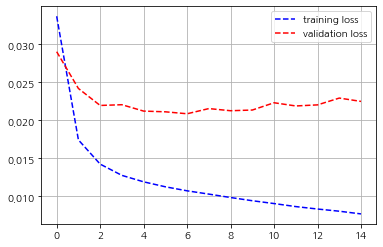

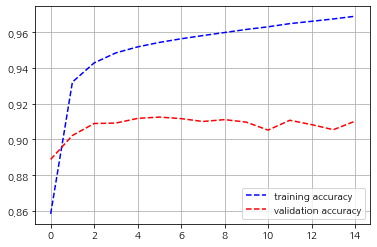

In [12]:
# 시각화
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training accuracy')
plt.plot(val_acc, 'r--', label = 'validation accuracy')
plt.legend()
plt.grid()

plt.show()

In [13]:
import numpy as np

# 임의 불용어
stopwords1 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords2 = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
stopwords = list(set(stopwords1 + stopwords2))

def sentiment_predict(new_sentence):
    new_token = [word for word in okt.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen = max_len)
    # score = float(loaded_model.predict(new_pad))
    score = loaded_model.predict(new_pad)
    # print(score)

    # print(np.argmax(score))

    if np.argmax(score) == 0 :
        print("{} -> 상승 ({:.2f}%)\n".format(new_sentence, score.max() * 100))
    elif np.argmax(score) == 1 :
        print("{} -> 유지 ({:.2f}%)\n".format(new_sentence, score.max() * 100))
    elif np.argmax(score) == 2 :
        print("{} -> 하락 ({:.2f}%)\n".format(new_sentence, score.max() * 100))

In [14]:
sentiment_predict("[유럽개장] 장초반 상승세…英 1.03%↑")
sentiment_predict("[시황종합] 코스피, '침체우려'에 장중 연저점 경신…2300선 턱걸이 마감")
sentiment_predict("[이번주 증시] 경기침체 우려 지속…반등시 포트폴리오 재정비")
sentiment_predict("'2차전지 너마저'…인플레·경기침체에 장사 없나 [한경우의 케이스스터디]")
sentiment_predict("기관 매도... 연일 증시 폭락")
sentiment_predict("코로나 확진자 3만명에 '비상'…여행-항공주 저가")
sentiment_predict("[특징주]지노믹트리, 핵산 증폭방법 특허 취득·미국 시장 진출 등 소식에 '강세'")
sentiment_predict("러시아 임플란트 수출 반토막에 주가급락한 덴티움…“피크아웃 판단은 시기상조”")

NameError: name 'okt' is not defined